In [1]:
import gymnasium as gym
import cookiedisaster
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from BaseAgent import AbstractAgent
print(torch.__version__)

SEED=2
np.random.seed(SEED)

# env = gym.make('cookiedisaster-v1')

2.2.2


In [2]:
# env.reset(seed=SEED) 
# # env.render()
# DUMMY_STATE=env.step(0)
# MAX_TIME=5*25 # 5 cookies elapse time
# PUNISHMENT=-1 # may have to be adjusted

# def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
#     return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

# def preprocess_state(state):
#     # Assuming state is a dictionary like:
#     # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
#     robot_pos = normalize(state[0]['agent']['pos'], 0, 10)
#     robot_vel = normalize(state[0]['agent']['vel'], -7, 7)
#     cookie_pos = normalize(state[0]['cookie']['pos'], 0, 10)
#     cookie_time = normalize(state[0]['cookie']['time'], 0, 5)
#     distance = robot_pos - cookie_pos
#     direction = 1 if distance > 0 else -1
    
#     # Return the normalized state as a numpy array
#     return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])


# class Actor(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Actor, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, output_dim),
#             nn.Softmax(dim=-1)
#         )
    
#     def forward(self, state):
#         return self.network(state)

# class Critic(nn.Module):
#     def __init__(self, input_dim):
#         super(Critic, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )
    
#     def forward(self, state):
#         return self.network(state)

# input_dim = 6  # From preprocess_state function
# output_dim = env.action_space.n

# actor = Actor(input_dim, output_dim)
# critic = Critic(input_dim)


# actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
# critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

# num_episodes = 1000
# gamma = 0.99  # Discount factor for future rewards

# episode_rewards = []  # Track rewards per episode
# action_counts = np.zeros(output_dim)
# def train_actor_critic(env, num_episodes=10, gamma=0.99, actor_lr=0.001, critic_lr=0.001):
#     # Environment and model parameters
#     input_dim = 6  # From preprocess_state function
#     output_dim = env.action_space.n

#     # Initialize models
#     actor = Actor(input_dim, output_dim)
#     critic = Critic(input_dim)

#     # Initialize optimizers
#     actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
#     critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    
#     # Training loop
    
    
#     for episode in range(num_episodes):
#         state = env.reset()
#         state = preprocess_state(state)
#         done = False
#         total_reward = 0
#         count = 0
#         epsilon_start = 1.0
#         epsilon_min = 0.01
#         epsilon_decay = 0.995

#         while not done:
            
#             state_tensor = torch.FloatTensor(state).unsqueeze(0)
#             action_probs = actor(state_tensor)
#             distribution = torch.distributions.Categorical(action_probs)
#             epsilon = max(epsilon_min, epsilon_start * epsilon_decay**episode)
#             if np.random.rand() < epsilon:
#                 action = env.action_space.sample()  # Random action
#             else:
#                 action = distribution.sample()
            
#             action_counts[action] += 1
#             next_state= env.step(action.item())
#             reward = next_state[1]
#             done = next_state[2]
            
#             if next_state[1]>0:
#                 break
#             # missed 5 cookies (MAX_TIME), minus points and break
#             if count>MAX_TIME:
#                 # env._cumulative_reward+=PUNISHMENT
#                 # total_reward+=PUNISHMENT
#                 break
#             count+=1
#             # if count>100:
#             #     print('count',count)
#             #     break
            
#             next_state = preprocess_state(next_state)
            
#             total_reward += reward
            
#             # Critic update
#             value = critic(state_tensor)
#             next_value = critic(torch.FloatTensor(next_state).unsqueeze(0))
#             td_error = reward + gamma * next_value * (1 - int(done)) - value
#             critic_loss = td_error.pow(2)
            
#             critic_optimizer.zero_grad()
#             critic_loss.backward()
#             critic_optimizer.step()
            
#             # Actor update
#             action = torch.tensor(action)
#             actor_loss = -distribution.log_prob(action) * td_error.detach()
            
#             actor_optimizer.zero_grad()
#             actor_loss.backward()
#             actor_optimizer.step()
            
#             state = next_state
            
        
#         episode_rewards.append(total_reward)
#         if episode % 100 == 0:
#             print(f"Episode {episode}, Total Reward: {total_reward}")
    
#     return actor, critic, episode_rewards, action_counts, episode_rewards

# def evaluate_policy(env, actor, num_episodes=100):
#     total_rewards = 0.0
#     rewards = []    
#     for _ in range(num_episodes):
#         state = env.reset()
#         state = preprocess_state(state)
#         done = False
#         total_reward = 0
#         count = 0

#         while not done:
#             if count > MAX_TIME:  # Break if max time exceeded without positive reward
#                 break
            
#             state_tensor = torch.FloatTensor(state).unsqueeze(0)
#             action_probs = actor(state_tensor)
#             distribution = torch.distributions.Categorical(action_probs)
#             action = distribution.sample()
            
#             next_state= env.step(action.item())
#             reward = next_state[1]
#             rewards.append(reward)
#             done = next_state[2]
            
#             if next_state[1]>0:
#                 break
            
#             if count>MAX_TIME:
                
#                 break
#             count+=1
          
            
#             next_state = preprocess_state(next_state)
            
            
#             total_reward += reward

       

#     average_reward = total_rewards / num_episodes
#     print(f"Average Reward over {num_episodes} episodes: {average_reward}")
#     return average_reward, rewards

# def find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, gamma=0.99, threshold_reward=None, max_iterations=10, eval_episodes=10):
#     actor_lr = initial_actor_lr
#     critic_lr = initial_critic_lr
    
#     best_average_reward = float('-inf')
#     best_actor = None

#     for iteration in range(max_iterations):
#         print(f"Iteration {iteration + 1}/{max_iterations}: Training Started")
#         actor, critic, episode_rewards, action_counts, episode_rewards= train_actor_critic(env, num_episodes=num_episodes, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr)
#         average_reward, rewards = evaluate_policy(env, actor, num_episodes=eval_episodes)
#         print(f"Iteration {iteration + 1}: Average Reward = {average_reward}")
        
#         # Check if the current model is the best one
#         if average_reward > best_average_reward:
#             best_average_reward = average_reward
#             best_actor = actor
#             print("New best model found!")
            
#             # Optional: Adjust learning rates based on performance, implement your strategy here
#             # actor_lr *= learning_rate_decay
#             # critic_lr *= learning_rate_decay
            
#         # If a threshold is defined and met, stop training
#         if threshold_reward is not None and average_reward >= threshold_reward:
#             print(f"Desired threshold reward of {threshold_reward} achieved.")
#             break
        
#         # Optional: Implement additional logic to adjust training parameters or terminate early
    
#     return best_actor, best_average_reward, rewards

# best_actor, best_reward, rewards = find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, threshold_reward=-2.5, max_iterations=num_episodes)
# print(f"Best average reward achieved: {best_reward}")


In [3]:
# def test_actor_critic(env, actor, episodes=num_episodes):
#     total_rewards = []
#     state = env.reset()
#     total_reward = 0
    
#     for _ in range(episodes):
#         state = preprocess_state(state)  # Adjust based on your state preprocessing
#         done = False
      
#         count = 0
        
        
      
#         state_tensor = torch.FloatTensor(state).unsqueeze(0)
#         q_values = actor(state_tensor)
#         action = torch.argmax(q_values).item()
#         next_state= env.step(action)
#         reward = next_state[1]
#         done = next_state[2]    
#         # next_state = preprocess_state(next_state)
#         state = next_state
#         total_reward += reward
        
#         total_rewards.append(total_reward)
    
#     avg_reward = np.mean(total_rewards)
#     print(f"Average reward over {episodes} episodes: {avg_reward}")
#     return avg_reward, total_rewards


In [4]:
# env = gym.make('cookiedisaster-v1',render_mode='human')
# avg_act, act_rewards=test_actor_critic(env, best_actor, episodes=500)
# env.close()


In [5]:
# env.close()

In [6]:
# from last time:

MAX_TIME=5*25 # 5 cookies elapse time

def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    robot_pos = normalize(state['agent']['pos'], 0, 10)
    robot_vel = normalize(state['agent']['vel'], -7, 7)
    cookie_pos = normalize(state['cookie']['pos'], 0, 10)
    cookie_time = normalize(state['cookie']['time'], 0, 5)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])

# Fra Chat:

In [15]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

class CookiePatrolAgent(AbstractAgent):
    def __init__(self, input_dim, output_dim, lr=0.001):
        super().__init__()
        self.policy = PolicyNetwork(input_dim, output_dim)
        self.value = ValueNetwork(input_dim)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)

    def select_action(self, observation):
        state_tensor = torch.FloatTensor(observation).unsqueeze(0)
        action_probs = self.policy(state_tensor)
        distribution = torch.distributions.Categorical(action_probs)
        action = distribution.sample()
        self.log_prob = distribution.log_prob(action)
        return action.item()

    def learn(self, state, reward, next_state, done):
        state_value = self.value(torch.FloatTensor(state).unsqueeze(0))
        next_state_value = self.value(torch.FloatTensor(next_state).unsqueeze(0))
        td_target = reward + (0.99 * next_state_value * (1 - int(done)))
        td_error = td_target - state_value
        
        # Critic loss
        critic_loss = td_error.pow(2)
        self.value_optimizer.zero_grad()
        critic_loss.backward()
        self.value_optimizer.step()

        # Actor loss
        actor_loss = -self.log_prob * td_error.detach()
        self.policy_optimizer.zero_grad()
        actor_loss.backward()
        self.policy_optimizer.step()

    def save(self, path):
        torch.save({'policy_state_dict': self.policy.state_dict(),
                    'value_state_dict': self.value.state_dict()}, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.value.load_state_dict(checkpoint['value_state_dict'])

# # Example of how to instantiate and use the agent
# env_parameters = {
#     'input_dim': 6,  # Adjust based on your environment observation space
#     'output_dim': 3  # Adjust based on your environment action space
# }
# agent = CookiePatrolAgent(**env_parameters)


In [16]:
def train_on_environments(envs, num_episodes_per_env=100, gamma=0.99):
    results = {}
    agent_parameters = {'input_dim': 6, 'output_dim': envs[0].action_space.n}
    agent = CookiePatrolAgent(**agent_parameters)
    
    for env in envs:
        episode_rewards = []
        for episode in range(num_episodes_per_env):
            state = env.reset()[0]
            # print('state',state)
            state = preprocess_state(state)
            done = False
            total_reward = 0
            count = 0
            while not done:
                if count > MAX_TIME:
                    break
                count+=1
                action = agent.select_action(state)
                next_state, reward, done, _, _ = env.step(action)
                # print('next_state',next_state)
                next_state = preprocess_state(next_state)

                agent.learn(state, reward, next_state, done)
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            if episode % 10 == 0:
                print(f"Environment {env.spec.id}: Episode {episode} Reward: {total_reward}")
        
        results[env.spec.id] = episode_rewards
    return results


cookie_1 = gym.make('cookiedisaster-v1')  
cookie_2 = gym.make('cookiedisaster-v2')
cookie_3 = gym.make('cookiedisaster-v3')

envs = [cookie_1, cookie_2, cookie_3]
all_env_results = train_on_environments(envs, num_episodes_per_env=100)

# Optionally, print or plot the results for each environment
for env_name, rewards in all_env_results.items():
    print(f"Results for {env_name}: Average Reward: {sum(rewards) / len(rewards)}")


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarnin

Environment cookiedisaster-v1: Episode 0 Reward: -6.46350165597594
Environment cookiedisaster-v1: Episode 10 Reward: 4.097916480337013
Environment cookiedisaster-v1: Episode 20 Reward: 2.5
Environment cookiedisaster-v1: Episode 30 Reward: 10.638171500316155
Environment cookiedisaster-v1: Episode 40 Reward: 12.84530321462844
Environment cookiedisaster-v1: Episode 50 Reward: 5.7832330337086315
Environment cookiedisaster-v1: Episode 60 Reward: 11.794913851191602
Environment cookiedisaster-v1: Episode 70 Reward: 13
Environment cookiedisaster-v1: Episode 80 Reward: 13.299445749591394
Environment cookiedisaster-v1: Episode 90 Reward: 14.804455523025396
Environment cookiedisaster-v2: Episode 0 Reward: 19.045768975029343
Environment cookiedisaster-v2: Episode 10 Reward: 19.046134496185463
Environment cookiedisaster-v2: Episode 20 Reward: 18.62955571563102
Environment cookiedisaster-v2: Episode 30 Reward: 21.862281177579604
Environment cookiedisaster-v2: Episode 40 Reward: 21.581859020929745
En

In [14]:
cookie_2.spec.kwargs['config']['width']

5

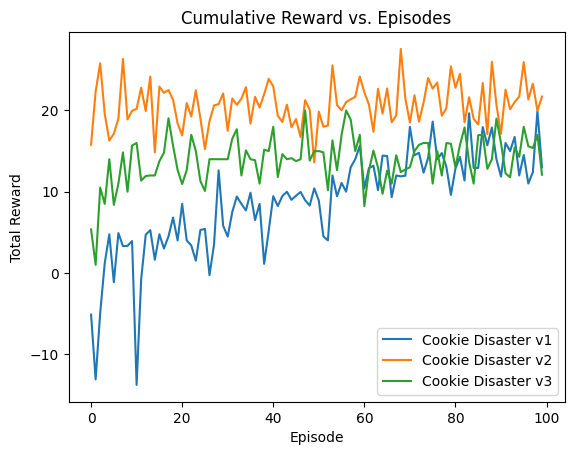

In [10]:
plt.plot(all_env_results[cookie_1.spec.id], label='Cookie Disaster v1')
plt.plot(all_env_results[cookie_2.spec.id], label='Cookie Disaster v2')
plt.plot(all_env_results[cookie_3.spec.id], label='Cookie Disaster v3')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Cumulative Reward vs. Episodes')
plt.legend()
plt.show()